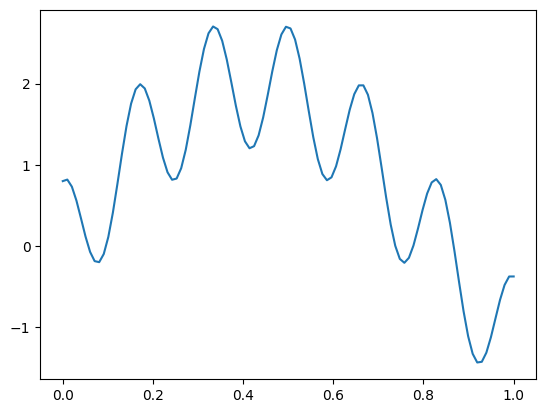

In [1]:
import torch
import matplotlib.pyplot as plt

objective = lambda x: 2 * torch.sin(3.14 * 1.2 * x) + 0.8 * torch.cos(3.14 * 12 * x)

test_x = torch.linspace(0, 1, 100)
test_y = objective(test_x)
plt.plot(test_x, test_y)

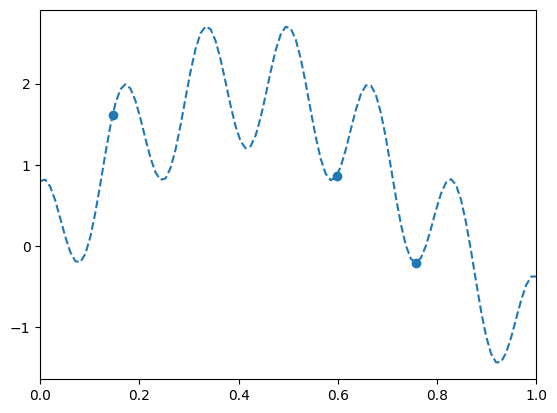

In [2]:
train_x = torch.zeros(3)
train_y = torch.zeros(3)
sobol = torch.quasirandom.SobolEngine(1, scramble=True)

for i in range(3):
    lr = sobol.draw(1)[0]
    train_x[i] = lr.item()
    train_y[i] = objective(lr).item()
plt.scatter(train_x, train_y)
plt.xlim(0, 1)
plt.plot(test_x, test_y, "--")

tensor([0.3333])
tensor(0.3333)


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\acquisition\analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpect

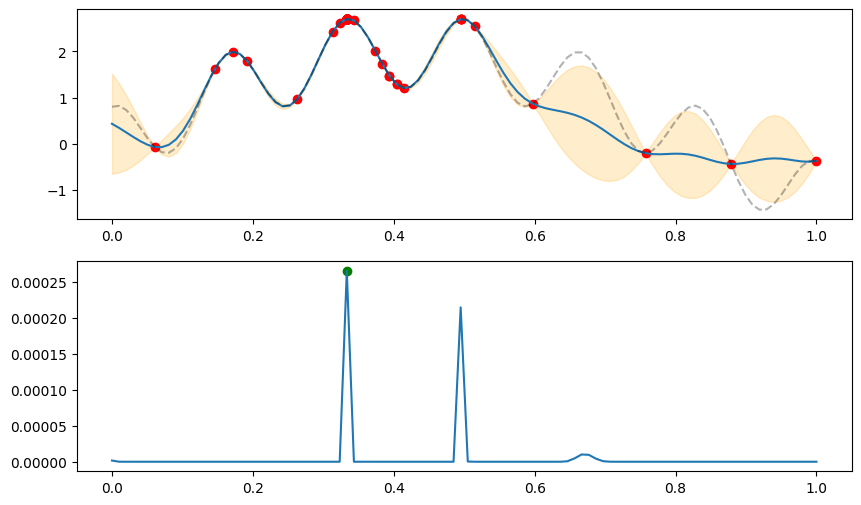

In [ ]:
# GP inference
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

gp = SingleTaskGP(
    train_X=train_x.unsqueeze(-1).to(torch.float64),
    train_Y=train_y.unsqueeze(-1).to(torch.float64),
)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

posterior = gp.posterior(torch.linspace(0, 1, 100).to(torch.float64))
mean = posterior.mean.detach().squeeze(-1)
std = posterior.variance.sqrt().detach().squeeze(-1)


# Calculate expected improvement and next LR
from botorch.acquisition import LogExpectedImprovement, ExpectedImprovement

ei = ExpectedImprovement(model=gp, best_f=train_y.max())
grid = torch.linspace(0, 1, steps=100).unsqueeze(-1).unsqueeze(-1)
ei_val = ei(grid)
next_lr = grid[ei_val.argmax()][0]

train_x = torch.cat([train_x, next_lr])
train_y = torch.cat([train_y, objective(next_lr)])
print(next_lr)


# Plotting
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(grid[:, 0, 0], mean)
plt.fill_between(
    grid[:, 0, 0], mean - 2 * std, mean + 2 * std, alpha=0.2, color="orange"
)
plt.scatter(train_x[:-1], train_y[:-1], color="red")
plt.plot(test_x, test_y, "--", color="black", alpha=0.3)
plt.subplot(2, 1, 2)
plt.plot(grid[:, 0, 0], ei_val.detach())
plt.scatter(grid[ei_val.argmax(0), 0, 0], ei_val.detach().max(), color="green")
print(grid[ei_val.argmax(0), 0, 0])